# Description

Runs hierarchical clustering on the umap version of the data.

# Environment variables

In [1]:
from IPython.display import display

import conf

N_JOBS = conf.GENERAL["N_JOBS"]
display(N_JOBS)

10

In [2]:
%env MKL_NUM_THREADS=$N_JOBS
%env OPEN_BLAS_NUM_THREADS=$N_JOBS
%env NUMEXPR_NUM_THREADS=$N_JOBS
%env OMP_NUM_THREADS=$N_JOBS

env: MKL_NUM_THREADS=10
env: OPEN_BLAS_NUM_THREADS=10
env: NUMEXPR_NUM_THREADS=10
env: OMP_NUM_THREADS=10


# Modules loading

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import generate_result_set_name

# Settings

In [5]:
np.random.seed(0)

In [6]:
NULL_DIR = conf.RESULTS["CLUSTERING_NULL_DIR"] / "shuffle_genes"

## Input data

In [7]:
INPUT_SUBSET = "umap"

In [8]:
INPUT_STEM = "z_score_std-projection-smultixcan-efo_partial-mashr-zscores"

In [9]:
# parameters of the dimentionality reduction steps
DR_OPTIONS = {
    "n_components": 50,
    "metric": "euclidean",
    "n_neighbors": 15,
    "random_state": 0,
}

In [10]:
input_filepath = Path(
    NULL_DIR,
    "data_transformations",
    INPUT_SUBSET,
    generate_result_set_name(
        DR_OPTIONS, prefix=f"{INPUT_SUBSET}-{INPUT_STEM}-", suffix=".pkl"
    ),
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/opt/data/results/clustering/null_sims/shuffle_genes/data_transformations/umap/umap-z_score_std-projection-smultixcan-efo_partial-mashr-zscores-metric_euclidean-n_components_50-n_neighbors_15-random_state_0.pkl')

'umap-z_score_std-projection-smultixcan-efo_partial-mashr-zscores-metric_euclidean-n_components_50-n_neighbors_15-random_state_0'

## Clustering

In [11]:
from sklearn.cluster import AgglomerativeClustering

In [12]:
CLUSTERING_ATTRIBUTES_TO_SAVE = ["n_clusters"]

In [13]:
CLUSTERING_OPTIONS = {}

CLUSTERING_OPTIONS["K_MIN"] = 2
CLUSTERING_OPTIONS["K_MAX"] = 75  # sqrt(3749) + some more to get closer to 295
CLUSTERING_OPTIONS["LINKAGE"] = {"ward", "complete", "average", "single"}
CLUSTERING_OPTIONS["AFFINITY"] = "euclidean"

display(CLUSTERING_OPTIONS)

{'K_MIN': 2,
 'K_MAX': 75,
 'LINKAGE': {'average', 'complete', 'single', 'ward'},
 'AFFINITY': 'euclidean'}

In [14]:
CLUSTERERS = {}

idx = 0

for k in range(CLUSTERING_OPTIONS["K_MIN"], CLUSTERING_OPTIONS["K_MAX"] + 1):
    for linkage in CLUSTERING_OPTIONS["LINKAGE"]:
        if linkage == "ward":
            affinity = "euclidean"
        else:
            affinity = "precomputed"

        clus = AgglomerativeClustering(
            n_clusters=k,
            affinity=affinity,
            linkage=linkage,
        )

        method_name = type(clus).__name__
        CLUSTERERS[f"{method_name} #{idx}"] = clus

        idx = idx + 1

In [15]:
display(len(CLUSTERERS))

296

In [16]:
_iter = iter(CLUSTERERS.items())
display(next(_iter))
display(next(_iter))

('AgglomerativeClustering #0', AgglomerativeClustering())

('AgglomerativeClustering #1',
 AgglomerativeClustering(affinity='precomputed', linkage='single'))

In [17]:
clustering_method_name = method_name
display(clustering_method_name)

'AgglomerativeClustering'

## Output directory

In [18]:
# output dir for this notebook
RESULTS_DIR = Path(
    NULL_DIR,
    "runs",
    f"{INPUT_SUBSET}-{INPUT_STEM}",
).resolve()
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

display(RESULTS_DIR)

PosixPath('/opt/data/results/clustering/null_sims/shuffle_genes/runs/umap-z_score_std-projection-smultixcan-efo_partial-mashr-zscores')

# Load input file

In [19]:
data = pd.read_pickle(input_filepath)

In [20]:
data.shape

(3752, 50)

In [21]:
data.head()

,UMAP1,UMAP2,UMAP3,UMAP4,UMAP5,UMAP6,UMAP7,UMAP8,UMAP9,UMAP10,...,UMAP41,UMAP42,UMAP43,UMAP44,UMAP45,UMAP46,UMAP47,UMAP48,UMAP49,UMAP50
100001_raw-Food_weight,3.507164,4.783988,2.721716,5.306452,3.881773,3.321169,4.960411,5.549141,4.841390,3.194715,...,9.187434,2.469095,1.234505,9.594598,0.333957,8.039461,5.482632,4.958725,2.801697,5.658304
100002_raw-Energy,3.606311,4.727725,2.704979,5.271563,3.724591,3.337485,4.781901,5.599291,4.791382,3.003243,...,9.121886,2.506307,1.227272,9.574743,0.344036,8.037237,5.477282,4.900286,2.729573,5.601664
100003_raw-Protein,3.594661,4.729409,2.682754,5.218021,3.652642,3.325793,4.771183,5.580573,4.820001,3.022622,...,9.097627,2.484138,1.221946,9.572356,0.339655,8.043584,5.472909,4.895183,2.765254,5.663905
100004_raw-Fat,3.459632,4.797582,2.755155,5.230875,3.784350,3.366962,4.942765,5.604582,4.731943,3.045358,...,9.124997,2.587374,1.199794,9.633430,0.286029,8.071218,5.476699,4.869335,2.766068,5.523112
100005_raw-Carbohydrate,3.436945,4.827942,2.761039,5.268426,4.005526,3.357875,5.036726,5.545567,4.842803,3.282768,...,9.181946,2.513265,1.200227,9.631493,0.349085,8.032649,5.486337,4.947569,2.811798,5.677997


In [22]:
assert not data.isna().any().any()

# Clustering

## Generate ensemble

In [23]:
from sklearn.metrics import pairwise_distances
from clustering.ensembles.utils import generate_ensemble

In [24]:
data_dist = pairwise_distances(data, metric=CLUSTERING_OPTIONS["AFFINITY"])

In [25]:
data_dist.shape

(3752, 3752)

In [26]:
pd.Series(data_dist.flatten()).describe().apply(str)

count            14077504.0
mean     3.0258994102478027
std       1.123066782951355
min                     0.0
25%      2.2383562326431274
50%      3.2953301668167114
75%      3.9533920884132385
max       5.173931121826172
dtype: object

In [27]:
ensemble = generate_ensemble(
    data_dist,
    CLUSTERERS,
    attributes=CLUSTERING_ATTRIBUTES_TO_SAVE,
    affinity_matrix=data_dist,
)

100%|██████████| 296/296 [16:55<00:00,  3.43s/it]


In [28]:
# the number should be close to 295 (the number of partitions generated by k-means/spectral clustering)
ensemble.shape

(296, 3)

In [29]:
ensemble.head()

,clusterer_params,partition,n_clusters
clusterer_id,,,
AgglomerativeClustering #0,"{'affinity': 'euclidean', 'compute_full_tree':...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
AgglomerativeClustering #1,"{'affinity': 'precomputed', 'compute_full_tree...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
AgglomerativeClustering #2,"{'affinity': 'precomputed', 'compute_full_tree...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
AgglomerativeClustering #3,"{'affinity': 'precomputed', 'compute_full_tree...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
AgglomerativeClustering #4,"{'affinity': 'euclidean', 'compute_full_tree':...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3


In [30]:
ensemble["n_clusters"].value_counts().head()

75    4
20    4
22    4
23    4
24    4
Name: n_clusters, dtype: int64

In [31]:
ensemble_stats = ensemble["n_clusters"].describe()
display(ensemble_stats)

count    296.000000
mean      38.500000
std       21.396182
min        2.000000
25%       20.000000
50%       38.500000
75%       57.000000
max       75.000000
Name: n_clusters, dtype: float64

## Testing

In [32]:
assert ensemble_stats["min"] > 1

In [33]:
assert not ensemble["n_clusters"].isna().any()

In [34]:
assert ensemble.shape[0] == len(CLUSTERERS)

In [35]:
# all partitions have the right size
assert np.all(
    [part["partition"].shape[0] == data.shape[0] for idx, part in ensemble.iterrows()]
)

In [36]:
# no partition has negative clusters (noisy points)
assert not np.any([(part["partition"] < 0).any() for idx, part in ensemble.iterrows()])

## Add clustering quality measures

In [37]:
from sklearn.metrics import calinski_harabasz_score

In [38]:
ensemble = ensemble.assign(
    ch_score=ensemble["partition"].apply(lambda x: calinski_harabasz_score(data, x))
)

In [39]:
ensemble.shape

(296, 4)

In [40]:
ensemble.head()

,clusterer_params,partition,n_clusters,ch_score
clusterer_id,,,,
AgglomerativeClustering #0,"{'affinity': 'euclidean', 'compute_full_tree':...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1698.436795
AgglomerativeClustering #1,"{'affinity': 'precomputed', 'compute_full_tree...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,0.213999
AgglomerativeClustering #2,"{'affinity': 'precomputed', 'compute_full_tree...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1465.542701
AgglomerativeClustering #3,"{'affinity': 'precomputed', 'compute_full_tree...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,1440.977424
AgglomerativeClustering #4,"{'affinity': 'euclidean', 'compute_full_tree':...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,2568.756279


## Save

In [41]:
output_filename = Path(
    RESULTS_DIR,
    generate_result_set_name(
        {k: v for k, v in CLUSTERING_OPTIONS.items() if k != "LINKAGE"},
        prefix=f"{clustering_method_name}-",
        suffix=".pkl",
    ),
).resolve()
display(output_filename)

PosixPath('/opt/data/results/clustering/null_sims/shuffle_genes/runs/umap-z_score_std-projection-smultixcan-efo_partial-mashr-zscores/AgglomerativeClustering-AFFINITY_euclidean-K_MAX_75-K_MIN_2.pkl')

In [42]:
ensemble.to_pickle(output_filename)

# Cluster quality

In [43]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    _df = ensemble.groupby(["n_clusters"]).mean()
    display(_df)

,ch_score
n_clusters,
2,1151.292730
3,1796.052242
4,1806.012778
5,1968.301829
6,2140.043906
7,2163.996282
8,2243.526218
9,2160.925646
10,2079.043246


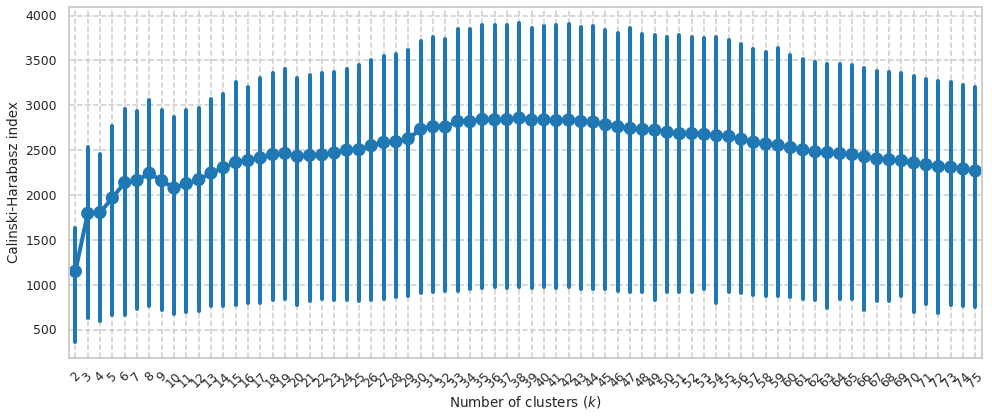

In [44]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=ensemble, x="n_clusters", y="ch_score")
    ax.set_ylabel("Calinski-Harabasz index")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()

# Stability

## Group ensemble by n_clusters

In [45]:
parts = ensemble.groupby("n_clusters").apply(
    lambda x: np.concatenate(x["partition"].apply(lambda x: x.reshape(1, -1)), axis=0)
)

In [46]:
parts.head()

n_clusters
2    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
3    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
4    [[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0,...
5    [[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0,...
6    [[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0,...
dtype: object

In [47]:
assert np.all(
    [
        parts.loc[k].shape == (len(CLUSTERING_OPTIONS["LINKAGE"]), data.shape[0])
        for k in parts.index
    ]
)

## Compute stability

In [48]:
from sklearn.metrics import adjusted_rand_score as ari
from scipy.spatial.distance import pdist

In [49]:
parts_ari = pd.Series(
    {k: pdist(parts.loc[k], metric=ari) for k in parts.index}, name="k"
)

In [50]:
parts_ari_stability = parts_ari.apply(lambda x: x.mean())
display(parts_ari_stability.sort_values(ascending=False).head(15))

8     0.367637
9     0.362386
7     0.335029
6     0.334901
10    0.332670
33    0.315127
13    0.314501
11    0.314057
35    0.313803
34    0.313478
12    0.313088
30    0.312312
39    0.311620
40    0.311558
36    0.311225
Name: k, dtype: float64

In [51]:
parts_ari_df = pd.DataFrame.from_records(parts_ari.tolist()).set_index(
    parts_ari.index.copy()
)

In [52]:
parts_ari_df.shape

(74, 6)

In [53]:
assert (
    int(
        (len(CLUSTERING_OPTIONS["LINKAGE"]) * (len(CLUSTERING_OPTIONS["LINKAGE"]) - 1))
        / 2
    )
    == parts_ari_df.shape[1]
)

In [54]:
parts_ari_df.head()

,0,1,2,3,4,5
2,-0.006024,0.195835,-0.011777,-0.005119,-0.007104,0.079460
3,-0.002559,0.374122,0.888254,0.001718,-0.002507,0.430757
4,0.001356,0.459332,0.637848,-0.000464,-0.004019,0.445960
5,-0.000437,0.687705,0.531198,-0.002635,-0.005338,0.526064
6,-0.001478,0.691392,0.717386,0.003993,-0.001549,0.599661


## Save

In [55]:
output_filename = Path(
    RESULTS_DIR,
    generate_result_set_name(
        CLUSTERING_OPTIONS,
        prefix=f"{clustering_method_name}-stability-",
        suffix=".pkl",
    ),
).resolve()
display(output_filename)

PosixPath('/opt/data/results/clustering/null_sims/shuffle_genes/runs/umap-z_score_std-projection-smultixcan-efo_partial-mashr-zscores/AgglomerativeClustering-stability-AFFINITY_euclidean-K_MAX_75-K_MIN_2-LINKAGE_ward_single_complete_average.pkl')

In [56]:
parts_ari_df.to_pickle(output_filename)

## Stability plot

In [57]:
parts_ari_df_plot = (
    parts_ari_df.stack()
    .reset_index()
    .rename(columns={"level_0": "k", "level_1": "idx", 0: "ari"})
)

In [58]:
parts_ari_df_plot.dtypes

k        int64
idx      int64
ari    float64
dtype: object

In [59]:
parts_ari_df_plot.head()

,k,idx,ari
0,2,0,-0.006024
1,2,1,0.195835
2,2,2,-0.011777
3,2,3,-0.005119
4,2,4,-0.007104


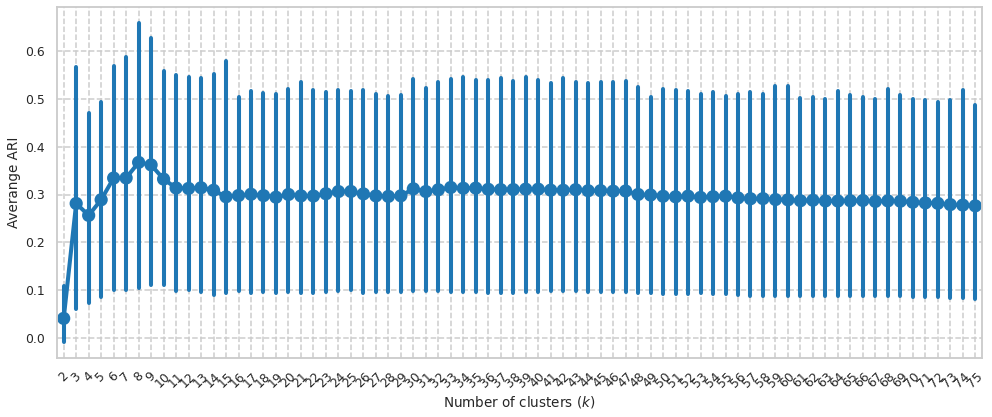

In [60]:
# with sns.axes_style('whitegrid', {'grid.linestyle': '--'}):
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=parts_ari_df_plot, x="k", y="ari")
    ax.set_ylabel("Averange ARI")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    #     ax.set_ylim(0.0, 1.0)
    #     ax.set_xlim(CLUSTERING_OPTIONS['K_MIN'], CLUSTERING_OPTIONS['K_MAX'])
    plt.grid(True)
    plt.tight_layout()